In [26]:

import tensorflow as tf
from tensorflow.keras import Model, layers
import numpy as np

In [27]:
# MNIST dataset parameters.
num_classes = 10 # total classes (0-9 digits).

# Training parameters.
learning_rate = 0.001
training_steps = 200
batch_size = 128
display_step = 10

# Network parameters.
conv1_filters = 32 # number of filters for 1st conv layer.
conv2_filters = 64 # number of filters for 2nd conv layer.
fc1_units = 1024 # number of neurons for 1st fully-connected layer.

In [28]:
# Prepare MNIST data.
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

In [29]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [30]:
# Create TF Model.
class ConvNet(Model):
    # Set layers.
    def __init__(self):
        super(ConvNet, self).__init__()
        # Convolution Layer with 32 filters and a kernel size of 5.
        self.conv1 = layers.Conv2D(32, kernel_size=5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with kernel size of 2 and strides of 2.
        self.maxpool1 = layers.MaxPool2D(2, strides=2)

        # Convolution Layer with 64 filters and a kernel size of 3.
        self.conv2 = layers.Conv2D(64, kernel_size=3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with kernel size of 2 and strides of 2.
        self.maxpool2 = layers.MaxPool2D(2, strides=2)

        # Flatten the data to a 1-D vector for the fully connected layer.
        self.flatten = layers.Flatten()

        # Fully connected layer.
        self.fc1 = layers.Dense(1024)
        # Apply Dropout (if is_training is False, dropout is not applied).
        self.dropout = layers.Dropout(rate=0.5)

        # Output layer, class prediction.
        self.out = layers.Dense(num_classes)

    # Set forward pass.
    def call(self, x, is_training=False):
        x = tf.reshape(x, [-1, 28, 28, 1])
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x, training=is_training)
        x = self.out(x)
        if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
        return x

# Build neural network model.
conv_net = ConvNet()

In [31]:
conv_net.summary()

Model: "conv_net_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Cross-Entropy Loss.
# Note that this will apply 'softmax' to the logits.
def cross_entropy_loss(x, y):
    # Convert labels to int 64 for tf cross-entropy function.
    y = tf.cast(y, tf.int64)
    # Apply softmax to logits and compute cross-entropy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    # Average loss across the batch.
    return tf.reduce_mean(loss)

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.Adam(learning_rate)

In [33]:
# Optimization process.
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        # Forward pass.
        pred = conv_net(x, is_training=True)
        # Compute loss.
        loss = cross_entropy_loss(pred, y)

    # Variables to update, i.e. trainable variables.
    trainable_variables = conv_net.trainable_variables

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)

    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [34]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)

    if step % display_step == 0:
        pred = conv_net(batch_x)
        loss = cross_entropy_loss(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 10, loss: 1.830759, accuracy: 0.757812
step: 20, loss: 1.663461, accuracy: 0.859375
step: 30, loss: 1.608324, accuracy: 0.906250
step: 40, loss: 1.544700, accuracy: 0.960938
step: 50, loss: 1.543456, accuracy: 0.945312
step: 60, loss: 1.549974, accuracy: 0.953125
step: 70, loss: 1.547803, accuracy: 0.937500
step: 80, loss: 1.554753, accuracy: 0.937500
step: 90, loss: 1.519184, accuracy: 0.976562
step: 100, loss: 1.503173, accuracy: 0.984375
step: 110, loss: 1.510714, accuracy: 0.968750
step: 120, loss: 1.501810, accuracy: 0.984375
step: 130, loss: 1.484037, accuracy: 1.000000
step: 140, loss: 1.498595, accuracy: 0.984375
step: 150, loss: 1.534465, accuracy: 0.937500
step: 160, loss: 1.495143, accuracy: 0.984375
step: 170, loss: 1.494944, accuracy: 0.984375
step: 180, loss: 1.498575, accuracy: 0.984375
step: 190, loss: 1.485784, accuracy: 0.992188
step: 200, loss: 1.503447, accuracy: 0.960938


In [35]:
# Test model on validation set.
pred = conv_net(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.980100


In [36]:
# Visualize predictions.
import matplotlib.pyplot as plt

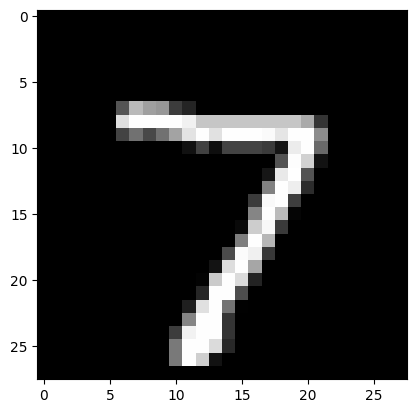

Model prediction: 7


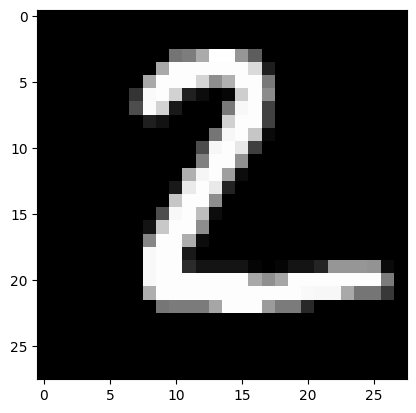

Model prediction: 2


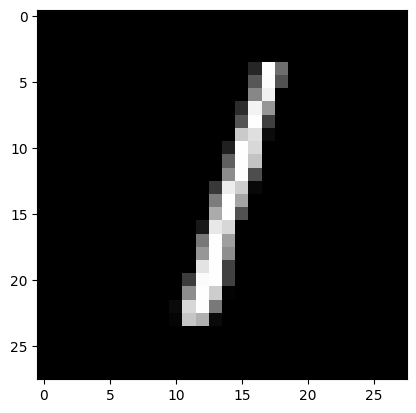

Model prediction: 1


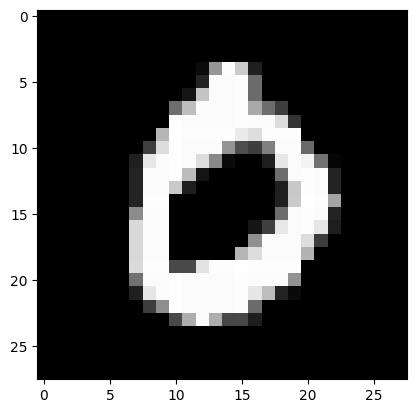

Model prediction: 0


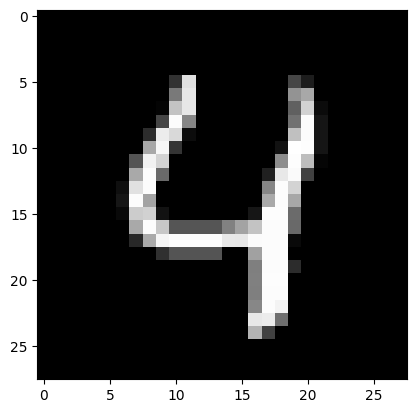

Model prediction: 4


In [37]:
# Predict 5 images from validation set.
n_images = 5
test_images = x_test[:n_images]
predictions = conv_net(test_images)

# Display image and model prediction.
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction: %i" % np.argmax(predictions.numpy()[i]))